In [28]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [58]:
def extract_yellow_card(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([23, 41, 133])  
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        yellow_card = img[y:y+h, x:x+w]
        return yellow_card
    else:
        return None  


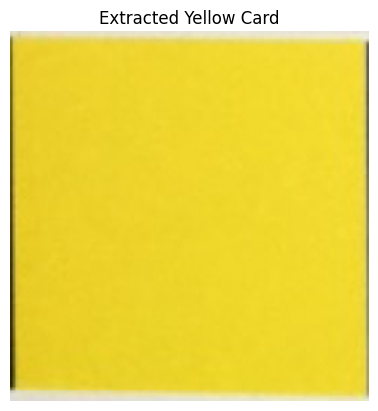

In [59]:
sample_card = extract_yellow_card(image_data[138])
if sample_card is not None:
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(sample_card, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Yellow Card")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not detected in this image.")

In [60]:
def compute_lab_means(lab_img):
    L, A, B = cv2.split(lab_img)
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color(full_img, yellow_card_img):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)
    lab_card = cv2.cvtColor(yellow_card_img, cv2.COLOR_BGR2LAB)
    
    L_card_mean, A_card_mean, B_card_mean = compute_lab_means(lab_card)
    target_L, target_A, target_B = 207.0, 121.0, 209.0  
    
    delta_L = target_L - L_card_mean
    delta_A = target_A - A_card_mean
    delta_B = target_B - B_card_mean
    
    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)
    
    return corrected_bgr


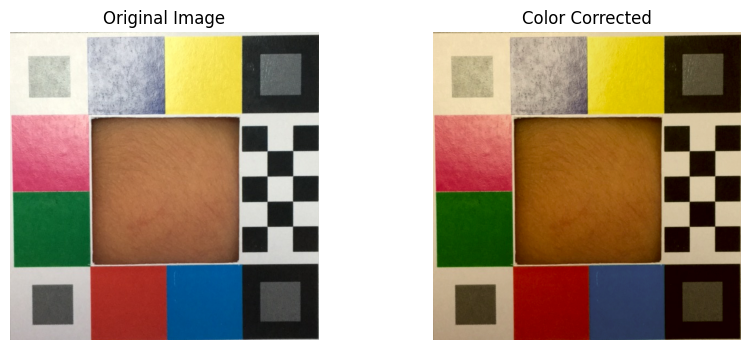

In [61]:
img = image_data[394]
yellow_card = extract_yellow_card(img)
if yellow_card is not None:
    corrected_img = correct_image_color(img, yellow_card)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.title("Color Corrected")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not found.")


In [63]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


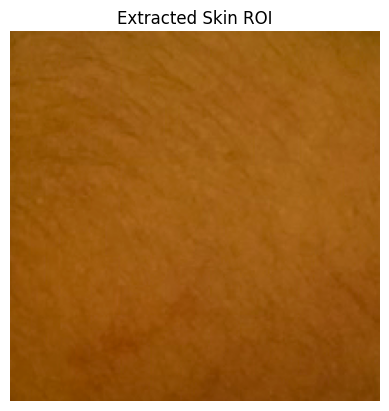

In [64]:
skin_roi = extract_skin_roi(corrected_img)

plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [65]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [66]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    yellow_card = extract_yellow_card(img)
    corrected_img = correct_image_color(img, yellow_card)
    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)

In [67]:
skin_roi.shape

(198, 198, 3)

In [68]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)

print(rgb[0])
print(hsv[0])
print(lab[0])


Processed HSV shape: (2235, 16384, 3)
Processed labels shape: (2235,)
[157 144 171]
[195 136  71]
[146 163  86]


In [69]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)

print(rgb_scaled.shape)


(2235, 3, 16384)


In [70]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=42)

In [71]:
print(processed_rgb.shape)
print(rgb_scaled.shape)
print(rgb_flat_scaled.shape)

(2235, 16384, 3)
(2235, 3, 16384)
(2235, 49152)


In [72]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

def conv_branch(input_tensor):
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    return x

def build_rgb_hsv_concat_model(input_shape):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    rgb_features = conv_branch(rgb_input)
    hsv_input = Input(shape=input_shape, name='hsv_input')
    hsv_features = conv_branch(hsv_input)

    combined = Concatenate()([rgb_features, hsv_features])
    
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_hsv_concat_model(input_shape)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 3, 32)                1572896   ['rgb_input[0][0]']           
                                                                                                  
 conv1d_20 (Conv1D)          (None, 3, 32)                1572896   ['hsv_input[0][0]']           
                                                                                            

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=2)
]

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_data=([rgb_val, hsv_val], y_val),
    epochs=150,
    batch_size=32,
    verbose=2,
    callbacks=callbacks
)


Epoch 1/150
49/49 - 5s - loss: 57.2267 - mae: 6.1346 - val_loss: 32.3939 - val_mae: 4.8938 - lr: 1.0000e-04 - 5s/epoch - 94ms/step
Epoch 2/150
49/49 - 3s - loss: 33.3856 - mae: 4.7745 - val_loss: 25.8933 - val_mae: 4.2645 - lr: 1.0000e-04 - 3s/epoch - 57ms/step
Epoch 3/150
49/49 - 3s - loss: 28.0948 - mae: 4.3398 - val_loss: 23.9403 - val_mae: 4.1331 - lr: 1.0000e-04 - 3s/epoch - 60ms/step
Epoch 4/150
49/49 - 3s - loss: 25.2552 - mae: 4.0632 - val_loss: 20.5466 - val_mae: 3.5808 - lr: 1.0000e-04 - 3s/epoch - 58ms/step
Epoch 5/150
49/49 - 3s - loss: 23.7595 - mae: 3.8935 - val_loss: 20.4485 - val_mae: 3.7110 - lr: 1.0000e-04 - 3s/epoch - 61ms/step
Epoch 6/150
49/49 - 3s - loss: 23.5220 - mae: 3.8719 - val_loss: 18.8156 - val_mae: 3.4925 - lr: 1.0000e-04 - 3s/epoch - 54ms/step
Epoch 7/150
49/49 - 2s - loss: 21.9405 - mae: 3.7363 - val_loss: 18.3278 - val_mae: 3.3677 - lr: 1.0000e-04 - 2s/epoch - 48ms/step
Epoch 8/150
49/49 - 3s - loss: 21.7559 - mae: 3.7389 - val_loss: 19.7360 - val_mae:

In [74]:
test_loss, test_mae = model.evaluate([rgb_test, hsv_test], y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_test, hsv_test])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")



15/15 - 0s - loss: 15.3478 - mae: 3.1283 - 142ms/epoch - 9ms/step
Test Loss (MSE): 15.3478
Test MAE: 3.1283
15/15 [==============================] - 0s 6ms/step
RMSE: 3.918
R²: 0.460


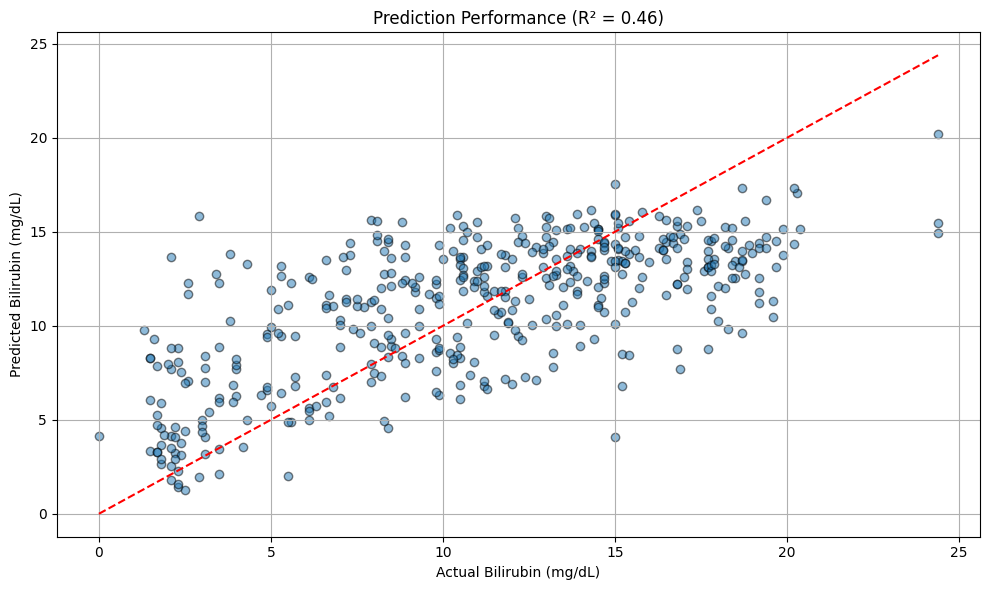

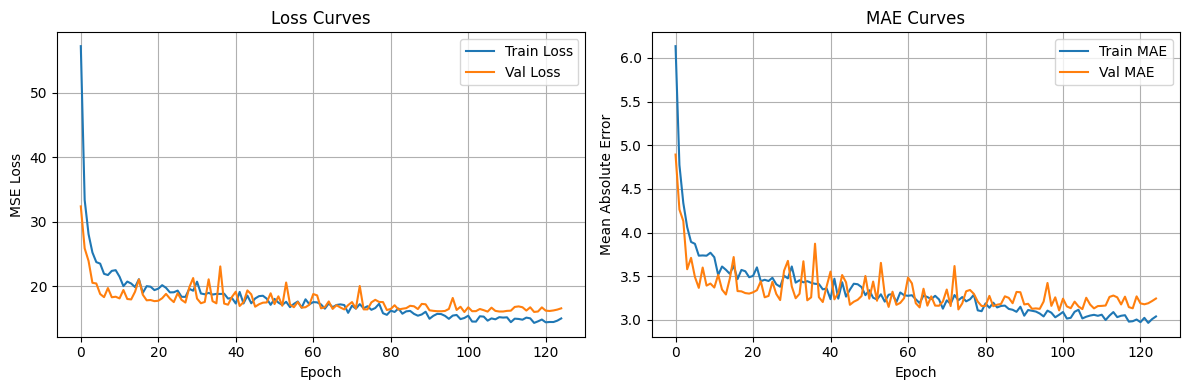

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of test')

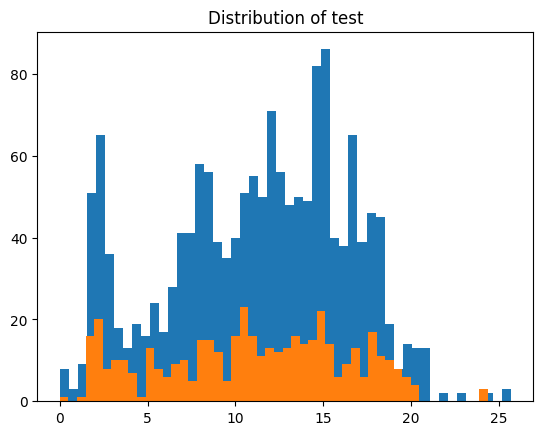

In [76]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=50)
plt.title("Distribution of train")

plt.hist(y_test.flatten(), bins=50)
plt.title("Distribution of test")


In [77]:
import numpy as np

def count_ranges(y_data, data_name):
    y_array = np.array(y_data)
    
    count_0_5 = np.sum((y_array >= 0) & (y_array < 5))
    count_5_10 = np.sum((y_array >= 5) & (y_array <= 10))
    count_above_10 = np.sum(y_array > 10)
    
    total = len(y_array)
    if total > 0:
        perc_0_5 = (count_0_5 / total) * 100
        perc_5_10 = (count_5_10 / total) * 100
        perc_above_10 = (count_above_10 / total) * 100
    else:
        perc_0_5 = perc_5_10 = perc_above_10 = 0
    
    print(f"\n{data_name} (Total: {total})")
    print(f"0-5 mg/dL: {count_0_5} ({perc_0_5:.2f}%)")
    print(f"5-10 mg/dL: {count_5_10} ({perc_5_10:.2f}%)")
    print(f">10 mg/dL: {count_above_10} ({perc_above_10:.2f}%)")

count_ranges(y_train, "Training set")
count_ranges(y_val, "Validation set")
count_ranges(y_test, "Test set")


Training set (Total: 1564)
0-5 mg/dL: 232 (14.83%)
5-10 mg/dL: 376 (24.04%)
>10 mg/dL: 956 (61.13%)

Validation set (Total: 221)
0-5 mg/dL: 35 (15.84%)
5-10 mg/dL: 47 (21.27%)
>10 mg/dL: 139 (62.90%)

Test set (Total: 450)
0-5 mg/dL: 78 (17.33%)
5-10 mg/dL: 108 (24.00%)
>10 mg/dL: 264 (58.67%)
